In [1]:
%%capture
!pip install transformers
!pip install sentencepiece
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [2]:
import torch
import transformers
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from IPython.display import HTML
from transformers import Trainer, TrainingArguments
from transformers import BertTokenizer
from transformers import BertPreTrainedModel, BertModel

import pandas as pd
import numpy as np
import re
import os

from sklearn.metrics import classification_report
from collections import defaultdict
# Full width display
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
test_df = pd.read_csv('/content/dev.csv')
#test_df['grades'] = test_df['grades'].str.replace('', ' ').str.strip()

In [5]:
def reader_train(filename, handle_anomalies='drop'):
    """Parses csv file blah blah
    Args:
        filename:
        handle_anomalies:
    Returns:
        train_dict:
    """
    # load csv to pandas for easier handling
    train_df = pd.read_csv(filename, dtype={'grades': 'string'})
    # parse and expand grades
    train_df['grades'] = train_df['grades'].str.replace('', ' ').str.strip()
    grade_names = []
    for i in range(15):
        grade_names.append(f'grade {i+1}')
    train_df[grade_names] = train_df['grades'].str.split(' ', expand=True)

    # Turn valid grades to int, missing ones to NaN
    train_df[grade_names] = train_df[grade_names].apply(pd.to_numeric, errors='coerce')

    # instances with 2 and 3 sets of grades
    two = train_df['grade 6'].notnull().to_numpy()
    three = train_df['grade 11'].notnull().to_numpy()

    if handle_anomalies == 'average': # average out the extra grades
        for i in range(1, 6):
            values = (train_df.loc[two, f'grade {i}'].to_numpy() + 
                      train_df.loc[two, f'grade {i+5}'].to_numpy()) / 2
            train_df.loc[two, f'grade {i}'] = values
            # slight hack here as it's not a proper average (1/4+1/4+1/2
            # instead of 1/3 each)
            values = (train_df.loc[three, f'grade {i}'].to_numpy() + 
                      train_df.loc[three, f'grade {i+10}'].to_numpy()) / 2
            train_df.loc[three, f'grade {i}'] = values

    elif handle_anomalies == 'drop': # simply drop the extra grades, recalculate
                                   # corresponding mean grades
        pass
    for i in range(6, 16):
        del train_df[f'grade {i}']
    del train_df['grades']

    # recalibrate the mean grade

    train_df['meanGrade'] = train_df[grade_names[:5]].mean(axis=1).values
    train_dict = train_df.to_dict()

    return train_dict, train_df

In [6]:
class HumicroeditDataset(torch.utils.data.Dataset):
    """Blah blah custom dataset class
        Returns:
            Dataset object
        """
    def __init__(self, tokenizer, input_set, pair=True):
        """
            Args:
                tokenizer:
                input_set:
                pair:
            Returns:
                Dataset object
        """
        self.tokenizer = tokenizer
        self.pair = pair
        self.ids = input_set['id']
        self.originals = input_set['original']
        self.edits = input_set['edit']
        self.grade_1s = input_set['grade 1']
        self.grade_2s = input_set['grade 2']
        self.grade_3s = input_set['grade 3']
        self.grade_4s = input_set['grade 4']
        self.grade_5s = input_set['grade 5']
        self.mean_grades = input_set['meanGrade']
        self.edited = defaultdict()
        self.changed_words = defaultdict()

        for id, orig, ed in zip(input_set['id'].values(), input_set['original'].values(), input_set['edit'].values()):
            self.changed_words[id] = re.findall("<(.*)/>", orig)[0]
            self.edited[id] = re.sub("<.*/>", ed, orig)
    
    def collate_fn(self, batch):
        originals = []
        ids = []
        edits = []
        grades_1 = []
        grades_2 = []
        grades_3 = []
        grades_4 = []
        grades_5 = []
        mean_grades = []
        changed_words = []
        edited = []
        for b in batch:
            ids.append(b['id'])
            originals.append(b['original'])
            edits.append(b['edit'])
            edited.append(self.edited[b['id']])
            changed_words.append(self.changed_words[b['id']])
            grades_1.append(b['grade 1'])
            grades_2.append(b['grade 2'])
            grades_3.append(b['grade 3'])
            grades_4.append(b['grade 4'])
            grades_5.append(b['grade 5'])
            mean_grades.append(b['mean grade'])

        #The maximum sequence size for BERT is 512 but here the tokenizer truncate sentences longer than 128 tokens.  
        # We also pad shorter sentences to a length of 128 tokens
        if self.pair:
            encodings = self.tokenizer(originals, edited, return_tensors='pt', padding=True, truncation=True, max_length=128)
        else:
            encodings = self.tokenizer(originals, return_tensors='pt', padding=True, truncation=True, max_length=128)
        labels = {}
        encodings['dataset_id'] = torch.tensor(ids)
        encodings['grade 1'] =  torch.tensor(grades_1)
        encodings['grade 2'] =  torch.tensor(grades_2)
        encodings['grade 3'] =  torch.tensor(grades_3)
        encodings['grade 4'] =  torch.tensor(grades_4)
        encodings['grade 5'] =  torch.tensor(grades_5)
        encodings['mean grade'] =  torch.tensor(mean_grades)
        
        return encodings
    
    def __len__(self):
        return len(self.originals)

    def __getitem__(self, idx):
        item = {'id': self.ids[idx],
                'original': self.originals[idx],
                'edit': self.edits[idx],
                'edited': self.edited[self.ids[idx]],
                'changed word': self.changed_words[self.ids[idx]],
                'grade 1': self.grade_1s[idx],
                'grade 2': self.grade_2s[idx],
                'grade 3': self.grade_3s[idx],
                'grade 4': self.grade_4s[idx],
                'grade 5': self.grade_5s[idx],
                'mean grade': self.mean_grades[idx],
                }
        return item

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
tokenizer

PreTrainedTokenizer(name_or_path='bert-base-cased', vocab_size=28996, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [188]:
# Sanitization
df['original'] = df['original'].str.replace('GOP', 'G.O.P.')
df['original'] = df['original'].str.replace('US', 'U.S.')
df['original'] = df['original'].str.replace('Sen\.', 'Senator')

df['original'] = df['original'].str.replace("'re|’re", 'are')
df['original'] = df['original'].str.replace("'m|’m", 'am')
df['original'] = df['original'].str.replace("ca+\s+n’t|ca+\s+n't", 'cannot')
df['original'] = df['original'].str.replace("n’t|n't", 'not')
df['original'] = df['original'].str.replace("'ll|’ll", 'will')

df['original'] = df['original'].str.replace("’+\s|‘+\s", '')
df['original'] = df['original'].str.replace("'+\s|’+$|'+$", '')
df['original'] = df['original'].str.replace("“|\"|”", '')
df['original'] = df['original'].str.replace(",", '')
df['original'] = df['original'].str.replace(';', ':')

df['original'] = df['original'].str.replace("@realDonaldTrump", 'Trump')

outlets = "- BBC News|- BBC New|- Vox| - Los Angeles Times| - CNN Video|\
 - Salon.com|- Breitbart|- The New York Times| - New York Times| - NBC News |\
 - Politics live| -- live stream| -- live updates| - CNNPolitics.com|\
 - Business Insider|- NBC News| - Global Witness"
df['original'] = df['original'].str.replace(outlets, '')

In [189]:
HTML(df['original'].reset_index().to_html())

,index,original
0,0,France is hunting down its citizens who joined <Isis/> without trial in Iraq
1,1,Pentagon claims 2000 % increase in Russian trolls after <Syria/> strikes . What does that mean ?
2,2,Iceland PM Calls Snap Vote as Pedophile Furor Crashes <Coalition/>
3,3,In an apparent first Iran and Israel <engage/> each other militarily
4,4,Trump was told weeks ago that Flynn misled <Vice/> President .
5,5,All 22 <promises/> Trump made in his speech to Congress in one chart
6,6,New DOJ alert system will flag <crimes/> against police
7,7,As Someone Who Grew Up Among Fundamentalist <Christians/> In The U.S. I am Surprised Anyone 's Surprised About Roy Moore
8,8,Canadians may pay more taxes than Americans but here 's what they get for their <money/>
9,9,Dutch minister resigns in drug baron <row/>


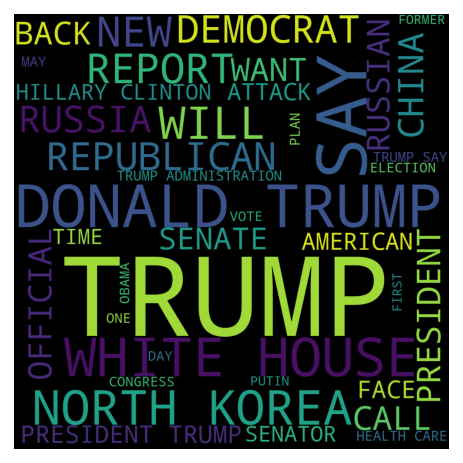

In [240]:
import wordcloud
text = df['original'].values
text = ' '.join(text)
wcloud = wordcloud.WordCloud()
wcloud.max_words = 40
wcloud.min_font_size = 6
wcloud.height, wcloud.width = 1000, 1000
wcloud.scale = 1
wcloud.generate(str(text.upper()))
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.imshow(wcloud)
plt.savefig('wcloud_orig.png')
plt.axis("off")
plt.show()

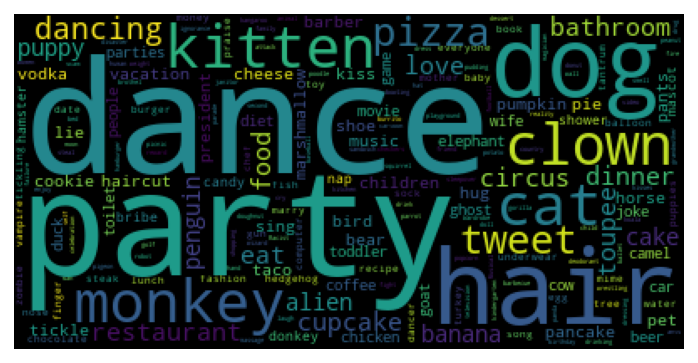

In [242]:
text = df['edit'].values
text = ' '.join(text)
wcloud = wordcloud.WordCloud()
wcloud.generate(str(text))
plt.imshow(wcloud)
plt.savefig('wcloud_edits.png')
plt.axis("off")
plt.show()

Text(0, 0.5, 'Number of Samples')

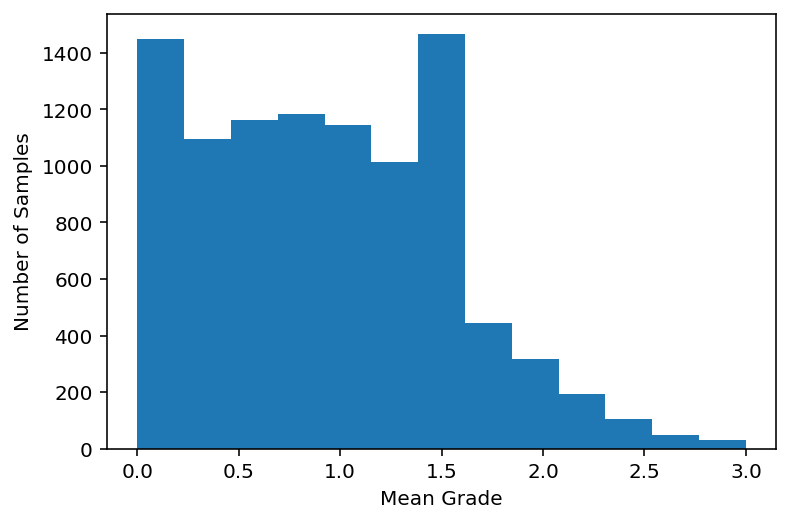

In [264]:
import seaborn as sns
sns.set_style()

_ = df['meanGrade'].hist(grid=False, bins=13) # \m/
plt.xlabel('Mean Grade')
plt.ylabel('Number of Samples')

#Unbalanced dataset

In [296]:
view = df[['grade 1', 'grade 2', 'grade 3', 'grade 4', 'grade 5']].std(axis=1)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


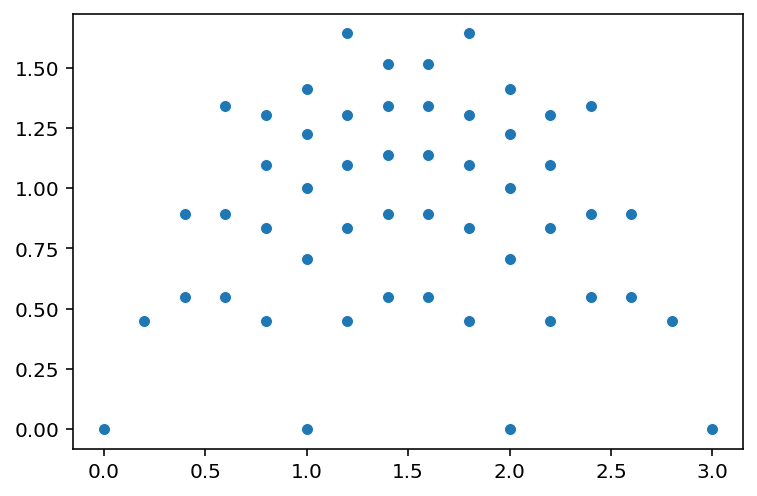

In [297]:
sns.scatterplot(df['meanGrade'].values, view.values)

In [313]:
print(f"Training set mean is: {df['meanGrade'].mean():.3f}")
print(f"Training set std is: {df['meanGrade'].std():.3f}")
print(f"Training set containing Trump mean is: {df[df['original'].str.contains('Trump')]['meanGrade'].mean():.3f}")

Training set mean is: 0.946
Training set std is: 0.596
Training set containing Trump mean is: 1.030


In [325]:
trunc_df = df[df['meanGrade']>1]

In [326]:
print(f"Training set mean is: {trunc_df['meanGrade'].mean():.3f}")
print(f"Training set std is: {trunc_df['meanGrade'].std():.3f}")
print(f"Training set containing Trump mean is: {trunc_df[trunc_df['original'].str.contains('Trump')]['meanGrade'].mean():.3f}")

Training set mean is: 1.581
Training set std is: 0.370
Training set containing Trump mean is: 1.621


In [9]:
trainset, df = reader_train('/content/train.csv')
#testset = reader_test('/content/dev.csv')

train_dataset = HumicroeditDataset(tokenizer, trainset)
#test_dataset = HumicroeditDataset(tokenizer, testset)

In [75]:
#returns first item as dictionnary
#print(train_dataset[0])

# put all train set into one batch for the collate_fn function
batch = []
for i in range(len(train_dataset)):
    batch.append(train_dataset[i])

encodings = train_dataset.collate_fn(batch[28:29])

for key, value in encodings.items():
  print(f"{key}: {value.numpy().tolist()}")


input_ids: [[101, 133, 3831, 15733, 21715, 120, 135, 8204, 1116, 10616, 1170, 1228, 16264, 1114, 8477, 1164, 1393, 7661, 17512, 15788, 27592, 117, 8979, 6652, 102, 6064, 8204, 1116, 10616, 1170, 1228, 16264, 1114, 8477, 1164, 1393, 7661, 17512, 15788, 27592, 117, 8979, 6652, 102]]
token_type_ids: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
attention_mask: [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
dataset_id: [2426]
grade 1: [3]
grade 2: [2]
grade 3: [1]
grade 4: [1]
grade 5: [1]
mean grade: [1.600000023841858]


In [76]:
encodings

{'input_ids': tensor([[  101,   133,  3831, 15733, 21715,   120,   135,  8204,  1116, 10616,
          1170,  1228, 16264,  1114,  8477,  1164,  1393,  7661, 17512, 15788,
         27592,   117,  8979,  6652,   102,  6064,  8204,  1116, 10616,  1170,
          1228, 16264,  1114,  8477,  1164,  1393,  7661, 17512, 15788, 27592,
           117,  8979,  6652,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'dataset_id': tensor([2426]), 'grade 1': tensor([3]), 'grade 2': tensor([2]), 'grade 3': tensor([1]), 'grade 4': tensor([1]), 'grade 5': tensor([1]), 'mean grade': tensor([1.6000])}

In [77]:
print(f'Tokenized: {tokenizer.convert_ids_to_tokens(encodings["input_ids"].flatten())}')

Tokenized: ['[CLS]', '<', 'Rose', '##anne', 'Barr', '/', '>', 'quit', '##s', 'Twitter', 'after', 'off', '##ending', 'with', 'statements', 'about', 'former', 'Obama', 'aide', 'Valerie', 'Jarrett', ',', 'Chelsea', 'Clinton', '[SEP]', 'Everyone', 'quit', '##s', 'Twitter', 'after', 'off', '##ending', 'with', 'statements', 'about', 'former', 'Obama', 'aide', 'Valerie', 'Jarrett', ',', 'Chelsea', 'Clinton', '[SEP]']


In [104]:
class BERT_regression(BertPreTrainedModel):

    def __init__(self, config):
        super().__init__(config)

        # BERT Model
        self.bert = BertModel(config)
        
        # Option 1
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.mean_layer = nn.Linear(config.hidden_size, 1)
        self.dropout = nn.Dropout(0.2)
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None):


        bert_outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hiddenstate_output = bert_outputs[0]
        cls_token_output = hiddenstate_output[:, 0]
        output = self.pre_classifier(cls_token_output)
        output = F.relu(output)
        output = self.dropout(output, p=0.2)
        output = self.mean_layer(output)

        # hack the output in the [0, 3] range
        output = 3 * torch.sigmoid(output)

        return output

In [105]:
class BERT_averaged_classification(BertPreTrainedModel):

    def __init__(self, config):
        super().__init__(config)

        # BERT Model
        self.bert = BertModel(config)
        
        # Option 2
        self.judge_1 = nn.Linear(config.hidden_size, 4)
        self.judge_2 = nn.Linear(config.hidden_size, 4)
        self.judge_3 = nn.Linear(config.hidden_size, 4)
        self.judge_4 = nn.Linear(config.hidden_size, 4)
        self.judge_5 = nn.Linear(config.hidden_size, 4)

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None):
 
        bert_outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        import pdb;pdb.set_trace()
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
    

        return output

In [106]:
loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=10, collate_fn=train_dataset.collate_fn)
config = transformers.BertConfig()
regression_model = BERT_regression(config).to(device)
optimizer = torch.optim.AdamW(params=regression_model.parameters())

In [107]:
# We define our training loop
def train_regression(loader_train, loader_val, model, epochs):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    """    
    print("Training model.")

    for epoch in range(1, epochs+1):

        model.train()
        epoch_loss = 0
        epoch_sse = 0
        no_observations = 0  # Observations used for training so far
        n_correct = 0
        nb_tr_steps = 0
        nb_tr_examples = 0

        for batch in loader_train:
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['mean grade'].to(device)

            predictions = model(ids, mask)
            optimizer.zero_grad()
            import pdb;pdb.set_trace()
            loss = F.MSELoss(predictions, targets)

            sse, __ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy())

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse

        valid_loss, valid_mse, __, __ = eval(dev_iter, model)

        epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_sse / no_observations
        print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {epoch_mse**0.5:.2f} | \
        Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {valid_mse**0.5:.2f} |')

In [108]:
train_regression(loader_train, _, regression_model, 2)

Training model.
> <ipython-input-107-8fa93a62341d>(26)train_regression()
-> loss = F.MSELoss(predictions, targets)
(Pdb) predictions
tensor([[1.6346],
        [1.4745],
        [1.6087],
        [1.4614],
        [1.3935],
        [1.6396],
        [1.4596],
        [1.6402],
        [1.5648],
        [1.4800]], grad_fn=<MulBackward0>)
(Pdb) targets
tensor([0.2000, 1.6000, 1.0000, 0.4000, 0.0000, 1.2000, 1.2000, 1.0000, 0.2000,
        0.0000])
(Pdb) q


BdbQuit: ignored

In [ ]:
def train(epoch):

    for _, data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)

        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return

In [ ]:
def train_averaged_classification(epoch):

    return

In [ ]:
main_hate_speech()

### Evaluation
Once we trained our model, we can evaluate it on our test set.

Let's define a helper function ``predict_hatespeech`` that will extract the predicted label.

In [ ]:
def predict_hatespeech(input, tokenizer, model): 
  model.eval()
  encodings = tokenizer(input, return_tensors='pt', padding=True, truncation=True, max_length=128)
  
  output = model(**encodings)
  preds = torch.max(output, 1)

  return {'prediction':preds[1], 'confidence':preds[0]}

Now let's define a function that will evaluate our model on the test set we prepared.

In [ ]:
def evaluate(model, tokenizer, data_loader)

  total_count = 0
  correct_count = 0 

  preds = []
  tot_labels = []

  with torch.no_grad():
    for data in tqdm(data_loader): 

      labels = {}
      labels['label_a'] = data['label_a']

      tweets = data['text']

      pred = predict_hatespeech(tweets, tokenizer, model)

      preds.append(pred['prediction'])
      tot_labels.append(labels['label_a'])

  #with the saved predictions and labels we can compute accuracy, precision, recall and f1-score
  report = classification_report(tot_labels, preds, target_names=["Not offensive","Offensive"], output_dict= True)

  return report

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

#your saved model name here
model_name = './models/ht_bert_finetuned/' 
model = BERT_hate_speech.from_pretrained(model_name)

# we don't batch our test set unless it's too big
test_loader = DataLoader(test_dataset)

report = evaluate(model, tokenizer, test_loader)

print(report)

print(report['accuracy'])
print(report['Not offensive']['f1-score'])
print(report['Offensive']['f1-score'])

Let's test our model on a few sentences to get an intuition. Feel free to play around.

In [ ]:
print(predict_hatespeech("I go see pinguins at the zoo.", tokenizer, model))
print(predict_hatespeech("Bananas are stupid", tokenizer, model))